In [67]:
%load_ext autoreload
%autoreload 2

# Model design
import agentpy as ap
import networkx as nx
import random
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import IPython

from EnergyShedModel import EnergyShedModel

random.seed(1)

POP_SIZE = 100
NUM_NEIGHBORS = 6
NUM_STEPS = 100
GRID_SIZE = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reflex agents

In [68]:
parameters = {"population": POP_SIZE, "steps": NUM_STEPS, "grid_size": (GRID_SIZE, GRID_SIZE)}

model = EnergyShedModel(parameters)
results = model.run()

Completed: 100 steps
Run time: 0:00:04.415818
Simulation finished


In [62]:
results.reporters

,seed,Per household energy transfer,Peak energy production,Total Energy Production,Total Energy Transfer,Total Cost
0,272996653310673477252411125948039410165,"[-1.2808997133679423, -0.13234174811451815, -0...",1000,82647.44479,-17723.801034,-7781.49862


In [63]:
results.variables.EnergyShedModel

,none,buy,sell,energy_production,energy_transfer,cost,weather
t,,,,,,,
0,1.00,0.00,0.0,1000.000000,0.000000,0.000000,Cloudy
1,0.55,0.45,0.0,869.964229,-126.025023,-119.087180,Sunny
2,0.46,0.54,0.0,900.932423,-94.499492,-266.729931,Sunny
3,0.55,0.45,0.0,913.011460,-78.949863,-396.808834,Sunny
4,0.11,0.89,0.0,710.103537,-287.140563,-419.393314,Cloudy
...,...,...,...,...,...,...,...
96,0.10,0.90,0.0,674.055736,-323.812078,-7535.169754,Cloudy
97,0.03,0.97,0.0,656.110088,-342.137068,-7543.152744,Cloudy
98,0.08,0.92,0.0,688.505650,-308.855867,-7584.234335,Cloudy


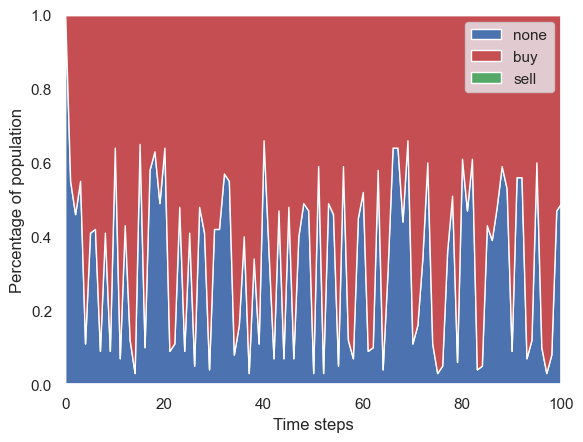

In [69]:
color_map = {"labels": ["none", "buy", "sell"], "colors": ["b", "r", "g"]}

def status_stackplot(data, ax):
    """Stackplot of people's condition over time."""
    x = data.index.get_level_values("t")
    y = [data[var] for var in ["none", "buy", "sell"]]

    sns.set()
    ax.stackplot(x, y, **color_map)

    ax.legend()
    ax.set_xlim(0, max(1, len(x) - 1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")


fig, ax = plt.subplots()
status_stackplot(results.variables.EnergyShedModel, ax)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


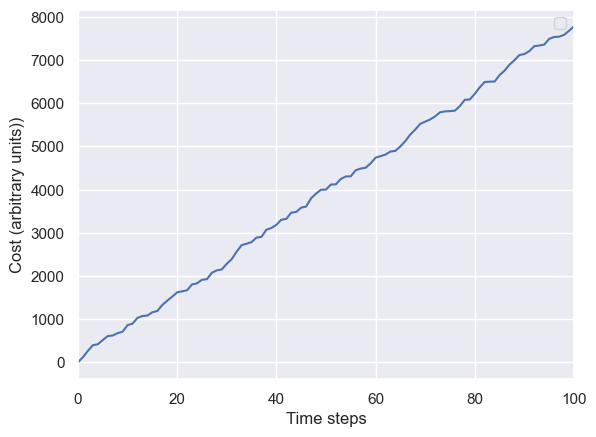

In [70]:
def cost_lineplot(data, ax):
    """Stackplot of people's condition over time."""
    x = data.index.get_level_values("t")
    y = -data["cost"]

    sns.set()
    ax.plot(x, y)

    ax.legend()
    ax.set_xlim(0, max(1, len(x) - 1))
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Cost (arbitrary units))")


fig, ax = plt.subplots()
cost_lineplot(results.variables.EnergyShedModel, ax)

In [71]:
def animation_plot(model, ax):
    group_grid = model.network.attr_grid('status')
    color_dict = {0: "b", -1: "r", 1: "g"}
    cmap = colors.ListedColormap([color_dict[key] for key in color_dict])  
    ap.gridplot(group_grid, cmap=cmap, ax=ax)
    ax.set_title(f"Energyshed model \n Time-step: {model.t}, "
                 f"Energy Transfer: {round(model.get_cost(), 3)},"
                 f"Weather: {model.get_weather()}")
    
fig, ax = plt.subplots()
model = EnergyShedModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml())

# Experiments

In [ ]:
parameters = {
    "population": ap.IntRange(100, 1000),
    "number_of_neighbors": 4,
    "network_randomness": ap.Range(0.0, 1.0),
}

sample = ap.Sample(parameters, n=128, method="saltelli", calc_second_order=False)

In [ ]:
exp = ap.Experiment(EnergyShedModel, sample, iterations=10)
results = exp.run()

In [ ]:
results.save()

In [ ]:
results

In [ ]:
results.reporters.hist();

In [ ]:
# Sensitivity Analysis

In [ ]:
results.calc_sobol()

In [ ]:
def plot_sobol(results):
    """Bar plot of Sobol sensitivity indices."""

    sns.set()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    si_list = results.sensitivity.sobol.groupby(by="reporter")
    si_conf_list = results.sensitivity.sobol_conf.groupby(by="reporter")

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):
        si = si.droplevel("reporter")
        err = err.droplevel("reporter")
        si.plot.barh(xerr=err, title=key, ax=ax, capsize=3)
        ax.set_xlim(0)

    axs[0].get_legend().remove()
    axs[1].set(ylabel=None, yticklabels=[])
    axs[1].tick_params(left=False)
    plt.tight_layout()


plot_sobol(results)

In [ ]:
def plot_sensitivity(results):
    """Show average simulation results for different parameter values."""

    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = [i for j in axs for i in j]  # Flatten list

    data = results.arrange_reporters().astype("float")
    params = results.parameters.sample.keys()

    for x, ax in zip(params, axs):
        for y in results.reporters.columns:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99, x_bins=15, fit_reg=False, label=y)
        ax.set_ylim(0, 1)
        ax.set_ylabel("")
        ax.legend()

    plt.tight_layout()


plot_sensitivity(results)